In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import os
import sys
import cv2
import random
import argparse
from torchvision.utils import flow_to_image 
sys.path.append("..")
from cake import BioX3D_Student
from teacher_utils import TeacherPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\hieuh\.conda\envs\MOOSE-main\Lib\site-packages\torch\backends\__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  self.setter(val)


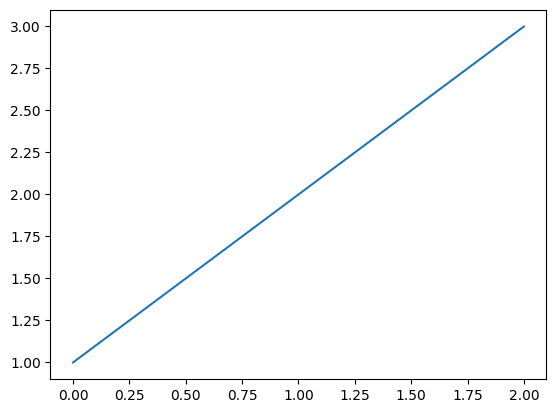

In [13]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import matplotlib.pyplot as plt
plt.plot([1, 2, 3])
plt.show()

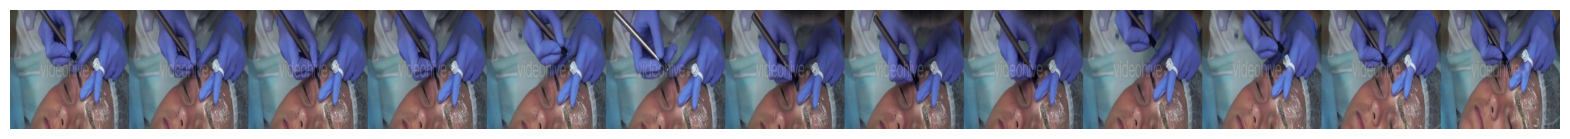

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_13_frames(video_path):
    # 1. Đọc video
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Không thể mở video: {video_path}")
        return

    # Lấy tổng số lượng frame để chia đều khoảng cách
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Tạo danh sách các chỉ số frame cần lấy (chia đều 13 điểm từ đầu đến cuối video)
    # Nếu video ngắn hơn 13 frame, code sẽ lấy tất cả frame có thể
    num_samples = 13
    frame_indices = np.linspace(0, total_frames - 1, num_samples, dtype=int)
    
    frames = []
    
    # 2. Lấy ra 13 frame
    for idx in frame_indices:
        # Di chuyển con trỏ đến đúng vị trí frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        
        if ret:
            # OpenCV đọc theo chuẩn BGR, cần chuyển sang RGB để plt hiển thị đúng màu
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # (Tùy chọn) Resize nhỏ lại để hiển thị đỡ bị quá nặng nếu video 4K/FullHD
            frame_rgb = cv2.resize(frame_rgb, (224, 224)) 
            
            frames.append(frame_rgb)
        else:
            break
            
    cap.release()

    if len(frames) > 0:
        # 3. np.hstack lại (nối theo chiều ngang)
        stacked_frames = np.hstack(frames)
        
        # 4. plt.imshow
        plt.figure(figsize=(20, 5)) # Thiết lập kích thước ảnh hiển thị to rộng
        plt.imshow(stacked_frames)
        plt.axis('off') # Tắt trục tọa độ cho đẹp
        plt.show()
    else:
        print("Không đọc được frame nào.")

# --- Chạy thử ---
# Thay 'duong_dan_video_cua_ban.mp4' bằng file video thực tế của bạn
visualize_13_frames(r'D:\project\Cake\cake\visualize\vid\sample_0003.mp4')

Thiết bị đang chạy: cuda
Đang đọc frame...
Đang tính Optical Flow...


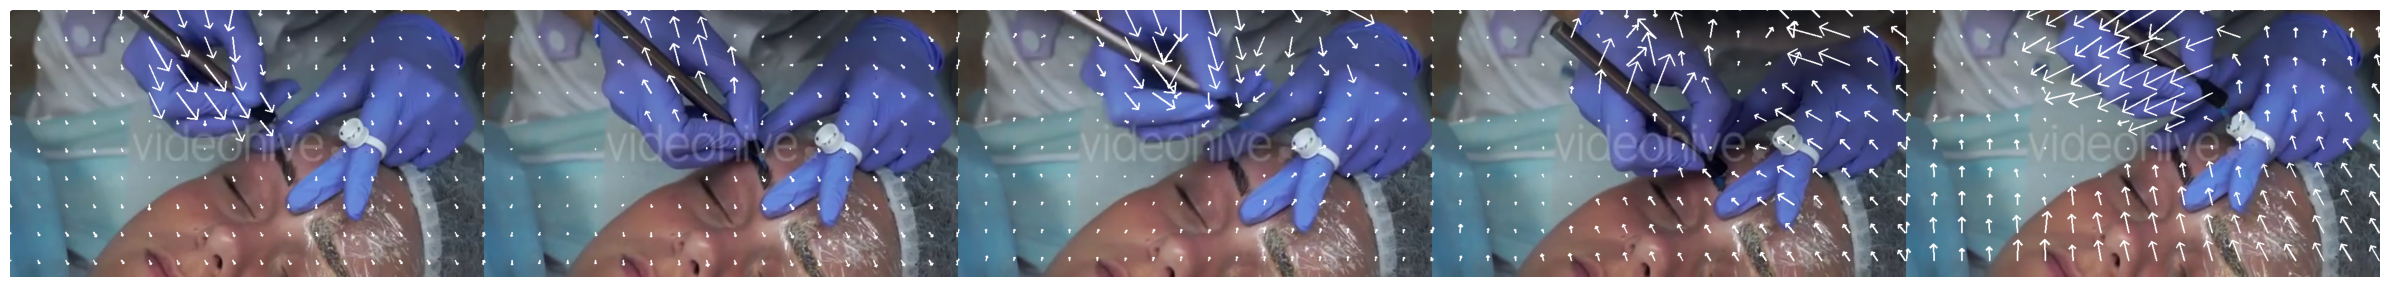

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import functional as FS
from torchvision.models.optical_flow import raft_large

# 1. SETUP THIẾT BỊ & MODEL RAFT
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Thiết bị đang chạy: {device}")

# Load model RAFT (Optical Flow)
raft_model = raft_large(pretrained=True, progress=False).eval().to(device)

def compute_optical_flow(frame1, frame2, model, device):
    # Chuẩn bị input (Resize chia hết cho 8)
    frame1_tensor = FS.to_tensor(frame1).unsqueeze(0).to(device)
    frame2_tensor = FS.to_tensor(frame2).unsqueeze(0).to(device)
    
    _, _, h, w = frame1_tensor.shape
    h_new = (h // 8) * 8
    w_new = (w // 8) * 8
    frame1_tensor = FS.resize(frame1_tensor, (h_new, w_new))
    frame2_tensor = FS.resize(frame2_tensor, (h_new, w_new))

    with torch.no_grad():
        flow = model(frame1_tensor, frame2_tensor)[0]
    
    # Output shape: [H, W, 2]
    return flow[0].permute(1, 2, 0).cpu().numpy()

def visualize_arrows_only(frame_rgb, optical_flow, step=32, scale=0.5):
    """
    Vẽ mũi tên Optical Flow lên frame.
    - step: Khoảng cách giữa các mũi tên (càng nhỏ càng dày đặc).
    - scale: Độ dài mũi tên nhân với độ lớn chuyển động.
    """
    flow = np.array(optical_flow)
    orig_h, orig_w = frame_rgb.shape[:2]
    flow_h, flow_w, _ = flow.shape

    # Resize flow về kích thước ảnh gốc nếu cần
    if (orig_h, orig_w) != (flow_h, flow_w):
        scale_y = orig_h / flow_h
        scale_x = orig_w / flow_w
        resized_flow = np.zeros((orig_h, orig_w, 2), dtype=np.float32)
        resized_flow[..., 0] = cv2.resize(flow[..., 0], (orig_w, orig_h)) * scale_x
        resized_flow[..., 1] = cv2.resize(flow[..., 1], (orig_w, orig_h)) * scale_y
        flow = resized_flow

    # Copy ảnh để vẽ (OpenCV vẽ trên BGR)
    vis_img = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
    H, W, _ = flow.shape

    # Vẽ mũi tên
    for y in range(0, H, step):
        for x in range(0, W, step):
            dx, dy = flow[y, x]
            # Lọc nhiễu: Chỉ vẽ nếu chuyển động đủ lớn (> 1 pixel)
            if np.sqrt(dx**2 + dy**2) > 1.0:
                start_point = (x, y)
                end_point = (int(x + scale * dx), int(y + scale * dy))
                
                # Giới hạn trong khung hình
                end_point = (max(0, min(W-1, end_point[0])), max(0, min(H-1, end_point[1])))
                
                # Vẽ mũi tên màu Đỏ (BGR: 0, 0, 255) cho nổi bật, độ dày = 2
                cv2.arrowedLine(vis_img, start_point, end_point, (255, 255, 255), thickness=2, tipLength=0.3)

    return cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)

def run_visualization(video_path):
    # 2. ĐỌC VIDEO VÀ LẤY 6 FRAME
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened(): print("Không mở được video"); return
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Lấy 6 điểm frame chia đều
    # (Lấy total-2 để đảm bảo luôn có frame kế tiếp t+1 để tính flow)
    frame_indices = np.linspace(0, total_frames - 2, 6, dtype=int)
    
    frames_rgb = []
    print("Đang đọc frame...")
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            # Resize nhẹ để hiển thị cho vừa màn hình (VD: Height 480px), giữ tỉ lệ
            # Nếu máy mạnh và màn hình to, bạn có thể bỏ dòng resize này
            h, w = frame.shape[:2]
            new_h = 480 
            new_w = int(w * (new_h / h))
            frame = cv2.resize(frame, (new_w, new_h))
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames_rgb.append(frame)
    cap.release()

    if len(frames_rgb) < 2: return

    processed_frames = []
    print("Đang tính Optical Flow...")
    
    # 3. XỬ LÝ
    # Chỉ chạy đến len - 1 vì frame cuối cùng không có frame sau để tính flow
    for i in range(len(frames_rgb) - 1):
        frame_curr = frames_rgb[i]
        frame_next = frames_rgb[i+1]
        
        # Tính Flow
        flow = compute_optical_flow(frame_curr, frame_next, raft_model, device)
        
        # Vẽ Mũi tên (Tùy chỉnh step và scale tại đây)
        # step=20: mật độ mũi tên vừa phải
        # scale=0.8: độ dài mũi tên
        vis_frame = visualize_arrows_only(frame_curr, flow, step=50, scale=0.8)
        
        processed_frames.append(vis_frame)

    # 4. SHOW KẾT QUẢ
    if processed_frames:
        # Nối ảnh lại
        result_strip = np.hstack(processed_frames)
        
        # Setup plot thật to
        plt.figure(figsize=(24, 6)) # Chiều ngang 24 inch, dọc 6 inch
        plt.imshow(result_strip)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# --- CHẠY THỬ ---
# Thay đường dẫn video của bạn
# run_big_visualization('path/to/your/video.mp4')
run_visualization(r'D:\project\Cake\cake\visualize\vid\sample_0003.mp4')

Processing: D:\project\Cake\cake\visualize\vid\sample_0007.mp4
-> Sampling Indices (Stride=2): [36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60]


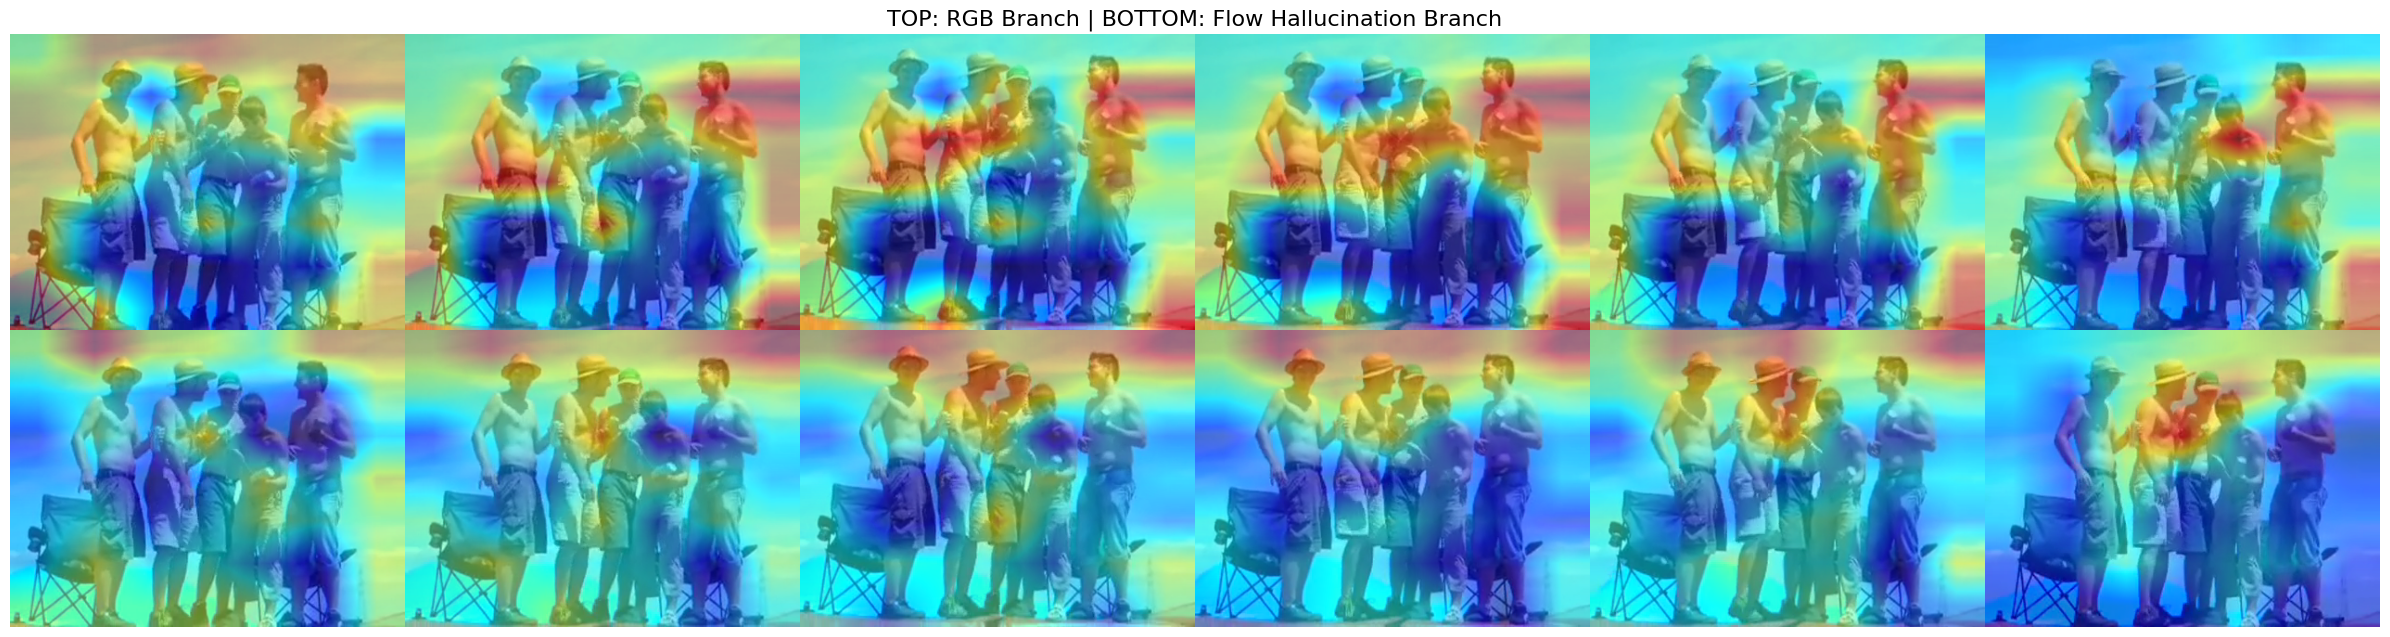

In [43]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import decord

# --- 1. SETUP & PREPROCESSING (Theo code tham khảo) ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class X3D_Normalizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mean = torch.tensor([0.45, 0.45, 0.45]).view(1, 3, 1, 1, 1).to(device)
        self.std = torch.tensor([0.225, 0.225, 0.225]).view(1, 3, 1, 1, 1).to(device)
    def forward(self, x): return (x / 255.0 - self.mean) / self.std

def load_video_with_stride(path, clip_len=13, stride=1, model_input_size=224):
    if not os.path.exists(path): raise FileNotFoundError(f"Not found: {path}")
    vr = decord.VideoReader(path)
    total = len(vr)
    required_frames = (clip_len - 1) * stride + 1
    
    if total > required_frames:
        start = random.randint(0, total - required_frames)
    else:
        start = 0
    
    indices = [min(start + i * stride, total - 1) for i in range(clip_len)]
    print(f"-> Sampling Indices (Stride={stride}): {indices}")
    
    buffer_full_res = vr.get_batch(indices).asnumpy() 
    full_res_imgs = list(buffer_full_res) # List of RGB images (H, W, 3)
    
    tensor = torch.from_numpy(buffer_full_res).permute(0, 3, 1, 2).float() 
    tensor = F.interpolate(tensor, size=(model_input_size, model_input_size), mode='bilinear', align_corners=False)
    tensor = tensor.permute(1, 0, 2, 3).unsqueeze(0) 
    
    return full_res_imgs, tensor.to(device)

# --- 2. HÀM XỬ LÝ HEATMAP (Đã thay bằng version tham khảo chuẩn) ---

def get_heatmap_sequence_full_res(feature_map, target_H, target_W):
    """
    Input: feature_map (B, C, T, H, W)
    Process: 
      1. Mean theo kênh C -> (B, T, H, W)
      2. Squeeze batch -> (T, H, W)
      3. Loop từng frame: Normalize Min-Max -> Resize OpenCV -> Apply ColorMap
    Output: List các ảnh Heatmap (BGR format) có kích thước bằng ảnh gốc.
    """
    # feature_map shape: (1, 192, 13, 7, 7) -> heatmap_t: (13, 7, 7)
    heatmap_t = feature_map.mean(dim=1).squeeze(0) 
    
    heatmaps_bgr = []
    for t in range(heatmap_t.shape[0]):
        hm = heatmap_t[t].detach().cpu().numpy()
        
        # Normalize per frame (để làm nổi bật đặc trưng trong khung hình đó)
        hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)
        
        # Resize về kích thước gốc
        hm_full = cv2.resize(hm, (target_W, target_H))
        
        # Tạo màu (JET) -> trả về BGR
        hm_bgr = cv2.applyColorMap(np.uint8(255 * hm_full), cv2.COLORMAP_JET)
        heatmaps_bgr.append(hm_bgr)
        
    return heatmaps_bgr

# --- 3. MAIN RUN ---

def run_final_viz(video_path):
    print(f"Processing: {video_path}")
    
    # A. Load Video
    try:
        CLIP_LEN = 13
        # Load video, trả về ảnh gốc (RGB) và tensor input
        full_res_imgs, input_tensor = load_video_with_stride(video_path, clip_len=CLIP_LEN, stride=2)
    except Exception as e:
        print(f"Lỗi load video: {e}")
        return

    # B. Inference
    input_tensor = X3D_Normalizer().to(device)(input_tensor)
    
    with torch.no_grad():
        # Gọi model (Giả sử model trả về: out_cls, features, rgb_map, flow_map)
        # Lưu ý: Bạn cần đảm bảo model trả về đúng thứ tự này
        _, _, rgb_feat_map, flow_hallucinated = model(input_tensor)
        
        # Debug shape
        # print(f"RGB Shape: {rgb_feat_map.shape}") # Expect: (1, C, 13, 7, 7)

    # C. Tạo Heatmap Sequence (List các ảnh BGR)
    orig_h, orig_w = full_res_imgs[0].shape[:2]
    
    # Xử lý RGB Heatmap
    list_hm_rgb = get_heatmap_sequence_full_res(rgb_feat_map, orig_h, orig_w)
    
    # Xử lý Flow Heatmap
    list_hm_flow = get_heatmap_sequence_full_res(flow_hallucinated, orig_h, orig_w)

    # D. Hiển thị (Lấy 6 frame đại diện để vẽ)
    indices_to_show = np.linspace(0, CLIP_LEN - 1, 6, dtype=int)
    
    vis_columns = []
    alpha = 0.5 # Độ trong suốt của heatmap
    
    for idx in indices_to_show:
        # 1. Lấy ảnh gốc (đang là RGB từ decord) -> Convert sang BGR để blend với heatmap
        frame_rgb = full_res_imgs[idx]
        frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
        
        # 2. Lấy heatmap tương ứng (đang là BGR)
        hm_rgb_bgr = list_hm_rgb[idx]
        hm_flow_bgr = list_hm_flow[idx]
        
        # 3. Blend (AddWeighted)
        # RGB Branch Overlay
        overlay_rgb_bgr = cv2.addWeighted(frame_bgr, 1.0 - alpha, hm_rgb_bgr, alpha, 0)
        # Flow Branch Overlay
        overlay_flow_bgr = cv2.addWeighted(frame_bgr, 1.0 - alpha, hm_flow_bgr, alpha, 0)
        
        # 4. Convert ngược lại RGB để hiển thị bằng Matplotlib
        viz_rgb = cv2.cvtColor(overlay_rgb_bgr, cv2.COLOR_BGR2RGB)
        viz_flow = cv2.cvtColor(overlay_flow_bgr, cv2.COLOR_BGR2RGB)
        
        # Ghép dọc (Trên: RGB, Dưới: Flow)
        col = np.vstack([viz_rgb, viz_flow])
        vis_columns.append(col)

    # Ghép ngang tất cả các cột
    final_grid = np.hstack(vis_columns)
    
    plt.figure(figsize=(24, 10))
    plt.imshow(final_grid)
    plt.axis('off')
    plt.title(f"TOP: RGB Branch | BOTTOM: Flow Hallucination Branch", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- CHẠY THỬ ---
# Thay đường dẫn video của bạn vào đây
run_final_viz('D:\\project\\Cake\\cake\\visualize\\vid\\sample_0007.mp4')

In [1]:
import torch
import torch.nn as nn
import sys
import argparse
from thop import profile, clever_format
import pandas as pd

# Import module của bạn (giữ nguyên path như code visualize)
sys.path.append("..")
from cake import BioX3D_Student
from teacher_utils import TeacherPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def analyze_module(name, model, input_tensor):
    """
    Hàm tính toán Params và FLOPs cho một nn.Module bất kỳ.
    """
    print(f"🔄 Analyzing {name}...")
    model.eval()
    model.to(device)
    input_tensor = input_tensor.to(device)

    # 1. Tính Params
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # 2. Tính FLOPs (MACs)
    # thop.profile trả về MACs (Multiply-Accumulate Operations)
    # Thông thường: 1 MAC ≈ 2 FLOPs
    try:
        macs, _ = profile(model, inputs=(input_tensor, ), verbose=False)
        gflops = 2 * macs / 1e9  # Convert to GFLOPS
    except Exception as e:
        print(f"⚠️ Warning: Could not auto-profile FLOPs for {name} (Reason: {e})")
        macs = 0
        gflops = 0

    return {
        "Model": name,
        "Params (M)": total_params / 1e6,
        "Trainable (M)": trainable_params / 1e6,
        "GFLOPs": gflops
    }

def main(args):
    # ==========================================================================
    # 1. SETUP INPUT DUMMY
    # ==========================================================================
    # Kích thước clip: (Batch=1, Channels=3, ClipLen=13, H=224, W=224)
    dummy_input = torch.randn(1, 3, args.clip_len, 224, 224).to(device)
    
    results = []

    # ==========================================================================
    # 2. ANALYZE STUDENT (Mô hình chính)
    # ==========================================================================
    print("🚀 Loading Student Model...")
    student = BioX3D_Student(clip_len=args.clip_len, feature_dim=192).to(device)
    
    # Tính tổng thể Student
    res_student = analyze_module("BioX3D_Student (Total)", student, dummy_input)
    results.append(res_student)

    # (Tùy chọn) Tính riêng từng phần của Student nếu bạn muốn chi tiết
    # Ví dụ: Nếu trong BioX3D_Student bạn có self.backbone và self.projector
    if hasattr(student, 'backbone'):
         res_backbone = analyze_module(" - Student Backbone", student.backbone, dummy_input)
         results.append(res_backbone)

    # ==========================================================================
    # 3. ANALYZE TEACHER (Để so sánh hiệu năng)
    # ==========================================================================
    # Teacher Pipeline thường rất nặng (RAFT + Backbone)
    # Lưu ý: TeacherPipeline trong code của bạn có thể phức tạp để profile trực tiếp
    # vì nó chứa RAFT (thường có các op custom). Ta sẽ thử bọc trong try-catch.
    if args.compare_teacher:
        print("\n🚀 Loading Teacher Model (for comparison)...")
        try:
            # Load Teacher (cần path weights thật hoặc dummy path nếu class cho phép)
            # Ở đây mình giả định bạn chỉ muốn check kiến trúc, weights không quan trọng
            teacher = TeacherPipeline(
                raft_weights=args.raft_weights, 
                flow_teacher_weights=args.flow_teacher_weights, 
                device=device
            )
            
            # Vì TeacherPipeline không hẳn là 1 nn.Module chuẩn (nó là wrapper),
            # ta nên profile backbone của nó (ví dụ self.flow_teacher) hoặc RAFT riêng.
            
            # Ví dụ: Profile RAFT (Rất nặng)
            # Lưu ý: RAFT input cần chuẩn hóa khác, nhưng thop chỉ quan tâm shape.
            # RAFT nhận 2 ảnh, ta cần chế input giả cho RAFT nếu muốn đo chính xác.
            # Ở đây mình demo đo Flow Backbone Teacher (phần dùng để Distill)
            if hasattr(teacher, 'flow_model'):
                # Flow model thường nhận input Flow (B, 2, T, H, W) hoặc tương tự
                # Giả sử output RAFT là (B, 2, T, H, W)
                dummy_flow = torch.randn(1, 2, args.clip_len, 224, 224).to(device)
                res_teacher = analyze_module("Teacher Flow Backbone", teacher.flow_model, dummy_flow)
                results.append(res_teacher)
                
        except Exception as e:
            print(f"⚠️ Không thể profile Teacher (có thể do thiếu weights hoặc kiến trúc phức tạp): {e}")

    # ==========================================================================
    # 4. REPORT
    # ==========================================================================
    print("\n" + "="*60)
    print(f"📊 REPORT: MODEL EFFICIENCY (Input: 1x3x{args.clip_len}x224x224)")
    print("="*60)
    
    df = pd.DataFrame(results)
    # Format đẹp
    print(df.to_string(index=False, float_format=lambda x: "{:.4f}".format(x)))
    
    print("-" * 60)
    if len(results) >= 2:
        student_flops = df.loc[df['Model'] == 'BioX3D_Student (Total)', 'GFLOPs'].values[0]
        # Giả sử cái cuối là Teacher hoặc cái lớn hơn là baseline
        baseline_flops = df['GFLOPs'].max()
        if baseline_flops > student_flops:
            ratio = baseline_flops / student_flops
            print(f"⚡ Speedup / Efficiency Gain: ~{ratio:.2f}x less computation than heaviest component.")
    print("="*60)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--clip_len', type=int, default=13)
    # Các tham số cho Teacher (cần file thật để load không bị lỗi)
    parser.add_argument('--compare_teacher', action='store_true', help="Bật cờ này nếu muốn đo cả Teacher")
    parser.add_argument('--raft_weights', type=str, default="path/to/raft.pth")
    parser.add_argument('--flow_teacher_weights', type=str, default="path/to/flow_teacher.pth")
    
    args = parser.parse_args()
    main(args)

c:\Users\hieuh\.conda\envs\MOOSE-main\Lib\site-packages\torch\backends\__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  self.setter(val)


🚀 Loading Student Model...
🛠️ Khởi tạo BioX3D Student...
🔄 Analyzing BioX3D_Student (Total)...

📊 REPORT: MODEL EFFICIENCY (Input: 1x3x13x224x224)
                 Model  Params (M)  Trainable (M)  GFLOPs
BioX3D_Student (Total)      6.4361         6.4361  8.3940
------------------------------------------------------------
